In [83]:
import json
from PIL import Image
from pprint import pprint
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from matplotlib.pyplot import imshow
import numpy as np


import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms 
from torchvision.datasets import MNIST
from torchvision.utils import save_image



In [84]:
with open('char.json') as f:
    char_list = json.load(f)

pprint(char_list["gbk"][0:5])


['阿', '啊', '锕', '呵', '吖']


In [85]:
%matplotlib inline
font_size = 28
fnt = ImageFont.truetype('heiti.ttc', 28)
train_x = None
for word in char_list["gbk"]:
    source_img = Image.new("L", (28, 28),(0))    
    draw = ImageDraw.Draw(source_img)
    draw.text((0,0), word, font=fnt, fill=(255))
#     imshow(np.asarray(source_img), cmap='gray')
#     source_img.save("outfile"+str(i), "png")
    source_img = np.asarray(source_img)
    if train_x is None:
        train_x = np.asarray([source_img])
    else:
        train_x = np.concatenate((train_x, np.asarray([source_img])), axis = 0)


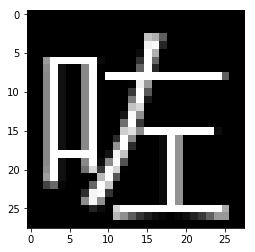

In [92]:
imshow(np.asarray(source_img), cmap='gray')


In [86]:
# saving and loading data
np.save("train_char_28",train_x)

In [125]:

train_x = np.load("train_char.npy")
print(train_x.shape)
train_x = torch.from_numpy(train_x)
train_x = train_x/255
train_x = torch.unsqueeze(train_x, 1)
train_x = train_x.type(torch.FloatTensor)
print(train_x.shape)
# all_images = torch.from_numpy(train_x.reshape((26635,1,28,28)))
dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)



(26635, 64, 64)
torch.Size([26635, 1, 64, 64])


In [126]:

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

char_dim = 64

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, char_dim, char_dim)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


In [127]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(char_dim * char_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12))
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, char_dim * char_dim), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img = data
        img = img.view(img.size(0), -1)
        img = img.type(torch.FloatTensor)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

/home/leon/venvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss:0.1282
epoch [2/100], loss:0.1175
epoch [3/100], loss:0.1009
epoch [4/100], loss:0.1116
epoch [5/100], loss:0.1107
epoch [6/100], loss:0.1013
epoch [7/100], loss:0.1004
epoch [8/100], loss:0.0969
epoch [9/100], loss:0.1043
epoch [10/100], loss:0.1035
epoch [11/100], loss:0.1050
epoch [12/100], loss:0.0996
epoch [13/100], loss:0.0957
epoch [14/100], loss:0.0958
epoch [15/100], loss:0.0887
epoch [16/100], loss:0.1026
epoch [17/100], loss:0.0980
epoch [18/100], loss:0.0998
epoch [19/100], loss:0.1094
epoch [20/100], loss:0.0953
epoch [21/100], loss:0.1012
epoch [22/100], loss:0.0976
epoch [23/100], loss:0.1011
epoch [24/100], loss:0.0979
epoch [25/100], loss:0.1045
epoch [26/100], loss:0.0861
epoch [27/100], loss:0.0926
epoch [28/100], loss:0.1016
epoch [29/100], loss:0.1023
epoch [30/100], loss:0.0970
epoch [31/100], loss:0.0870
epoch [32/100], loss:0.0988
epoch [33/100], loss:0.0913
epoch [34/100], loss:0.0914
epoch [35/100], loss:0.0936
epoch [36/100], loss:0.0896
e

In [157]:

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os

if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, char_dim, char_dim)
    return x


num_epochs = 100
batch_size = 32
learning_rate = 1e-3

# img_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# dataset = MNIST('./data', transform=img_transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
#         img,_ = data
        img = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './dc_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './conv_autoencoder.pth')


/home/leon/venvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss:0.1257
epoch [2/100], loss:0.0968
epoch [3/100], loss:0.0928
epoch [4/100], loss:0.1096
epoch [5/100], loss:0.1040
epoch [6/100], loss:0.1026
epoch [7/100], loss:0.0943
epoch [8/100], loss:0.1069
epoch [9/100], loss:0.0935
epoch [10/100], loss:0.0879
epoch [11/100], loss:0.0969
epoch [12/100], loss:0.0924
epoch [13/100], loss:0.1019
epoch [14/100], loss:0.0866
epoch [15/100], loss:0.0981
epoch [16/100], loss:0.0932
epoch [17/100], loss:0.1042
epoch [18/100], loss:0.1005
epoch [19/100], loss:0.0933
epoch [20/100], loss:0.0901
epoch [21/100], loss:0.0860
epoch [22/100], loss:0.0908
epoch [23/100], loss:0.0918
epoch [24/100], loss:0.0879
epoch [25/100], loss:0.0928
epoch [26/100], loss:0.0937
epoch [27/100], loss:0.1018
epoch [28/100], loss:0.1105
epoch [29/100], loss:0.1092
epoch [30/100], loss:0.0942
epoch [31/100], loss:0.0930
epoch [32/100], loss:0.0984
epoch [33/100], loss:0.0909
epoch [34/100], loss:0.0889
epoch [35/100], loss:0.1005
epoch [36/100], loss:0.0929
e

In [119]:
print(img.shape)

torch.Size([11, 1, 28, 28])


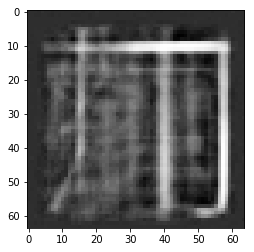

In [133]:
imshow(np.asarray(output[10].cpu().view(char_dim, char_dim).detach().numpy()), cmap='gray')

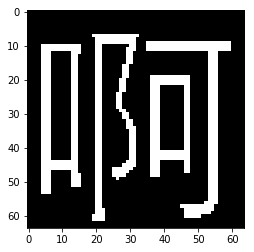

In [155]:
imshow(np.asarray(train_x[1].view(char_dim, char_dim).detach().numpy()), cmap='gray')

In [149]:
train_x[0][0].cuda()

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [151]:
output[0].shape

torch.Size([4096])

In [153]:
num_0 = model.encoder(train_x[0].reshape(char_dim*char_dim).cuda())
num_1 = model.encoder(train_x[1].reshape(char_dim**2).cuda())
changes = generate_latent_space_vectors(num_0, num_1, 10)
pic = to_img(model.decoder(changes).cpu().data)

save_image(pic, '3-9.png')





In [134]:
num_9 = model.encoder(output[3])

In [135]:
num_3 = model.encoder(output[0])

In [136]:
def generate_latent_space_vectors(a, b, steps):
    results = [a * x / steps + b * (steps - x) / steps for x in range(0, steps + 1)]
    return torch.stack(results)

In [137]:
changes = generate_latent_space_vectors(num_9, num_3, 10)


In [138]:
pic = to_img(model.decoder(changes).cpu().data)

save_image(pic, '3-9.png')




In [139]:
x = 0.35
num_93 = model.decoder(num_3 * x + num_9 * (1 - x))
imshow(np.asarray(num_93.cpu().view(28,28).detach().numpy()), cmap='gray')

RuntimeError: invalid argument 2: size '[28 x 28]' is invalid for input with 4096 elements at /pytorch/aten/src/TH/THStorage.c:41

In [46]:
i = 0
for data in dataloader:
    if i == 0 :
        print(data[0].shape)
    else :
        break

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([12

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
torch.Size([12

In [73]:
img = torch.from_numpy(train_x.reshape((26635,1,64,64)))
img = img.view(img.size(0), -1)
img = Variable(img).cuda()
print(img.shape)

torch.Size([26635, 4096])


In [79]:
dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# img, _ = data
# img = img.view(img.size(0), -1)
# img = Variable(img).cuda()

print(dataloader.shape)

AttributeError: 'DataLoader' object has no attribute 'shape'